In [1]:
# define logging and working directory
from ProjectRoot import change_wd_to_project_root
change_wd_to_project_root()
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"
#os.environ["TF_FORCE_GPU_ALLOW_GROWTH"] = "true"

import random
from collections import Counter
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 30})
import pandas as pd
import numpy as np
import scipy.interpolate
from scipy.interpolate import interp1d
from src.utils.Notebook_imports import *
from src.data.Preprocess import clip_quantile
from src.data.Dataset import load_phase_reg_exp

from ipywidgets import interact
import ipywidgets as widgets
from IPython.core.display import display, HTML
%matplotlib inline
%reload_ext autoreload
%autoreload 2

search for root_dir and set working directory
Working directory set to: /mnt/ssd/git/dynamic-cmr-models


/tmp/ipykernel_176354/580178597.py:22: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


## 0.1 Link to medical definition of the cardiac function

[source](https://next.amboss.com/de/article/xL0E-g)

Systole
1.) Anspannungsphase

    Hauptfunktion: Ventrikel kontrahieren sich
    Ablauf
        Alle Klappen sind geschlossen und die Ventrikel sind mit Blut gefüllt
        Isovolumetrische Kontraktion des Arbeitsmyokards 

    Druckanstieg in den Ventrikeln, bis der Druck in der Aorta bzw. dem Truncus pulmonalis überschritten ist
    Passive Öffnung der Taschenklappen (Pulmonal- und Aortenklappe) → Beginn der Austreibungsphase

Status des linken Ventrikels

    Druck: Anstieg von ca. 8 mmHg auf ca. 80 mmHg 

Volumen: Gleichbleibend ca. 150 mL (isovolumetrische Anspannung)
2.) Austreibungsphase

    Hauptfunktion: Blut wird aus Ventrikeln in Kreislauf und Lunge gepumpt
    Ablauf
        Blut strömt aus den Ventrikeln in den Truncus pulmonalis bzw. die Aorta (Großteil bereits zu Beginn der Austreibungsphase)
        Weitere Kontraktion des Myokards (beginnend am distalen Septum und der Herzspitze)
        Wanddicke der Ventrikel ↑ und Innendurchmesser der Ventrikel ↓
        Druck in den Ventrikeln ↑ (Laplace-Gesetz) → Blutvolumen ↓ im Ventrikel
        Druck ↓ langsam im Ventrikel (bis unter den Druck der Aorta bzw. Truncus pulmonalis)
        Schluss der Taschenklappen → Beginn der Entspannungsphase
    Status des linken Ventrikels
        Druck: Anstieg von ca. 80 mmHg auf ca. 120 mmHg, danach Absinken 

Volumen: Austreibung von ca. 90 mL Schlagvolumen (150 mL → 60 mL)
Diastole
3.) Entspannungsphase

    Hauptfunktion: Ventrikel entspannen sich
    Ablauf
        Alle Herzklappen sind geschlossen (Volumen bleibt konstant)
        Weitere Entspannung des Myokards (Druck ↓ in den Ventrikeln)
        Isovolumetrische Entspannung
        Ventrikeldruck fällt unter den Druck in den Vorhöfen
        Segelklappen öffnen sich → Beginn der Füllungsphase
    Status des linken Ventrikels
        Druck: Absinken auf ca. 10 mmHg 

Volumen: Gleichbleibend ca. 60 mL (isovolumetrische Entspannung)
4.) Füllungsphase

    Hauptfunktion: Ventrikel füllen sich erneut mit Blut
    Ablauf
        Die Ventilebene hebt sich und "stülpt" sich über die Blutsäule in den Vorhöfen (Ventilebenenmechanismus)
        Am Ende der Diastole kontrahieren die Vorhöfe kurz
        Druck im Ventrikel übersteigt den Druck der Vorhöfe
        Schluss Segelklappen → Beginn der Anspannungsphase
    Status des linken Ventrikels
        Druck: ca. 8 mmHg 

Volumen: Füllung mit ca. 90 mL (60 mL → 150 mL)

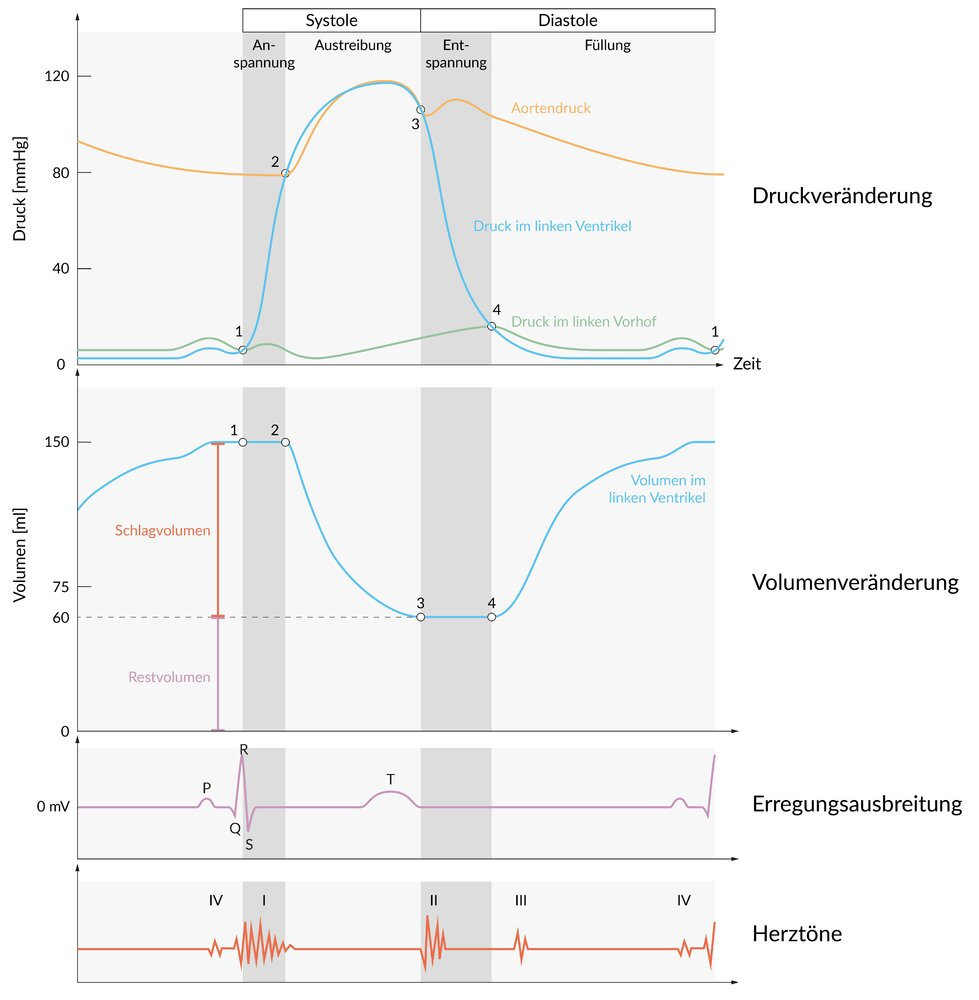

In [2]:
from IPython import display as disp
disp.Image("https://media-de.amboss.com/media/thumbs/big_5f22e89d3edf1.jpg")

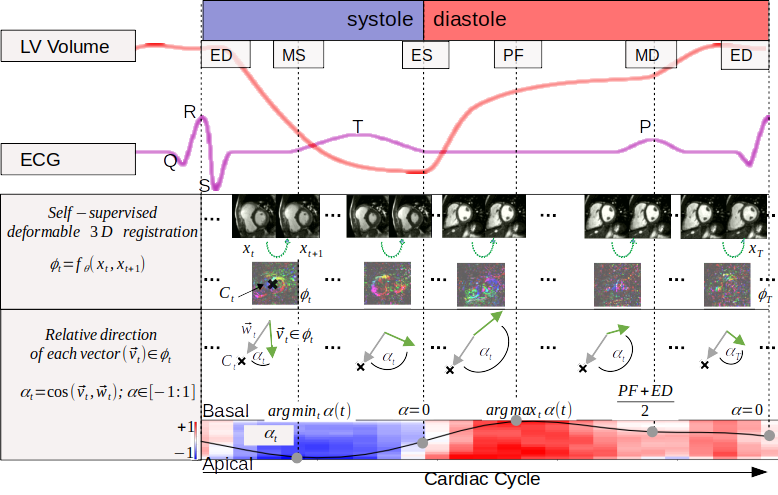

In [3]:
# mapping between the 5 defined cardiac phases and the lv volume curve
disp.Image("notebooks/Dataset/overview.png")

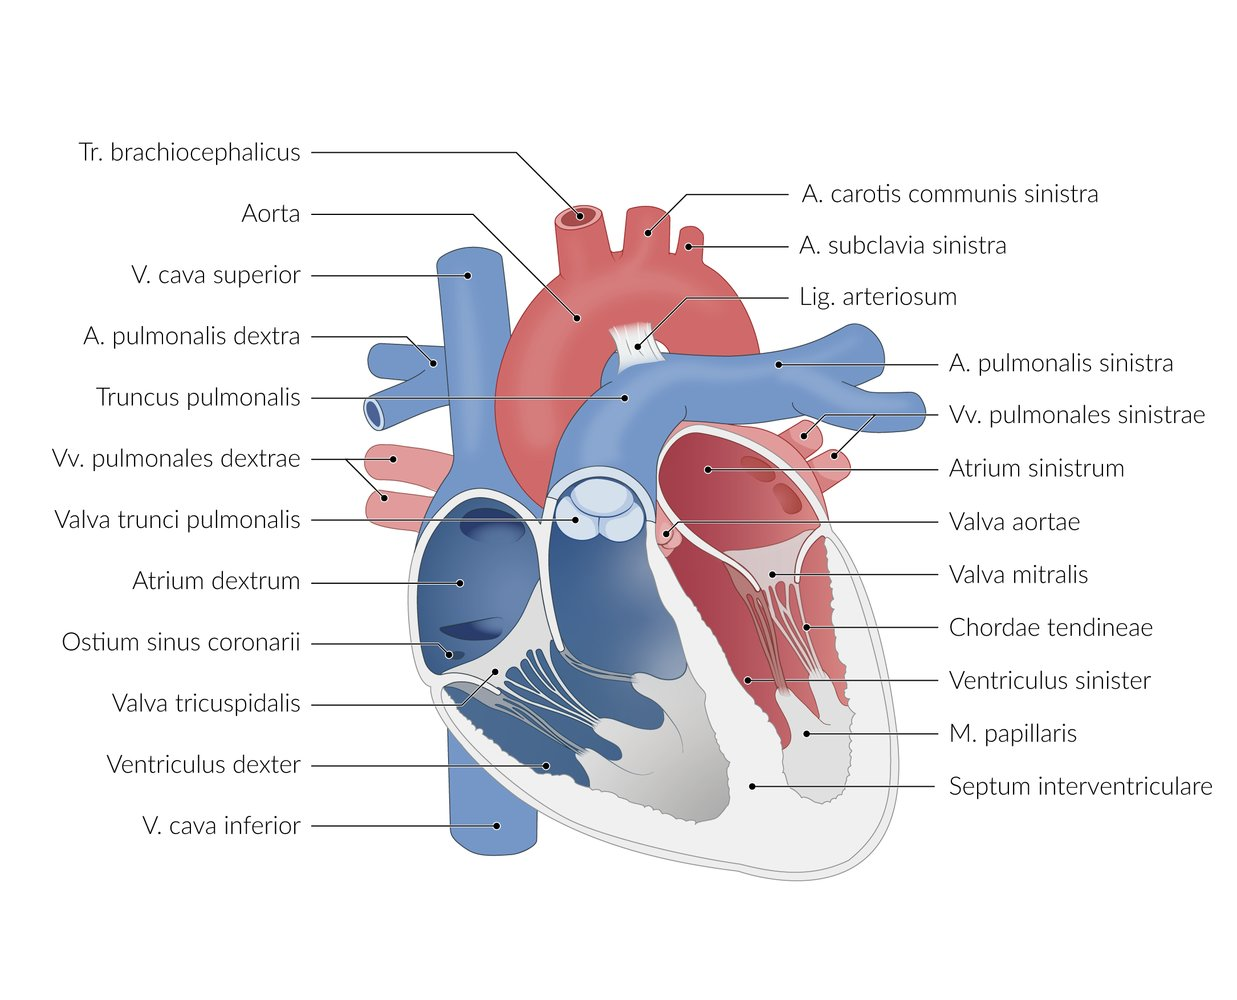

In [4]:
disp.Image("https://media-de.amboss.com/media/thumbs/big_5e147f74d36fe.jpg")

# 1. Load phase-vector and gt/pred from a project

In [2]:
from ipyfilechooser import FileChooser
vects_chooser = FileChooser(os.path.join(os.getcwd(),'/mnt/ssd/git/dynamic-cmr-models/exp/phasereg_v3/acdc/'), '')
display(vects_chooser)

FileChooser(path='/mnt/ssd/git/dynamic-cmr-models/exp/phasereg_v3/acdc', filename='', title='HTML(value='', la…

In [3]:
# load the vectors
temp = '/mnt/ssd/git/dynamic-cmr-models/exp/phasereg_v3/acdc/roll2lv/phaseloss0_2lstm32_gcn/2022-02-21_19_10/'
# load all files of this experiment
nda_vects, gt, pred, gt_len, mov, patients = load_phase_reg_exp(vects_chooser.selected)

['/mnt/hdd/cmr_phase_detection_experiments/2022-12-16_13_33_397073/phase_regression/inference_mnm2/moved/vects_f0.npy']
(360, 40, 24, 64, 64, 3)
['/mnt/hdd/cmr_phase_detection_experiments/2022-12-16_13_33_397073/phase_regression/inference_mnm2/pred/gtpred_fold0.npy']
(2, 360, 2, 40, 5)
(1, 360, 2, 40, 5)
(360, 40, 5)
1
(360, 40, 24, 64, 64, 1)


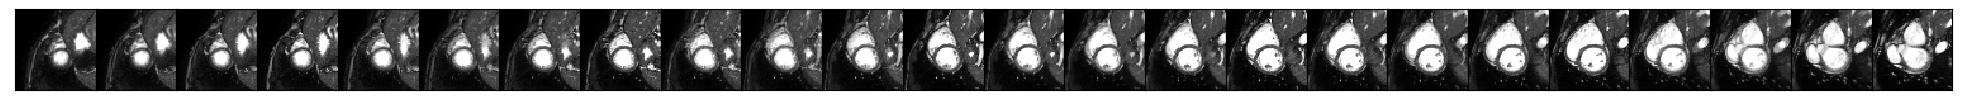

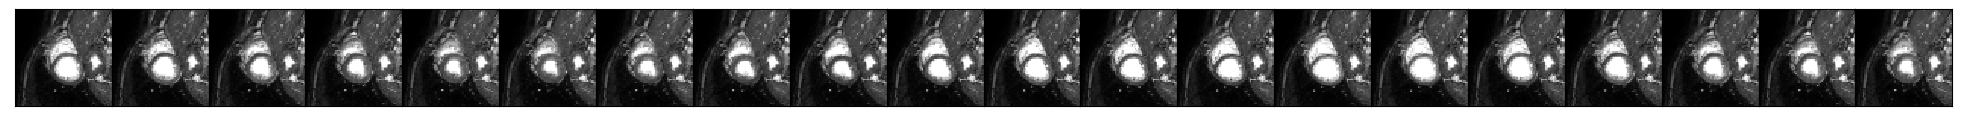

In [4]:
# plot one moved timestep of one patient = one 3D volume 
# should go from apex to base
from src.visualization.Visualize import show_2D_or_3D
example = 20
# apex to base, one t
t0_moved = mov[example,0,...,0]
_ = show_2D_or_3D(t0_moved, cmap='gray', interpolation='none')
# one slice over time
z8_moved = mov[example,:,8,...,0]
_ = show_2D_or_3D(z8_moved, cmap='gray', interpolation='none')

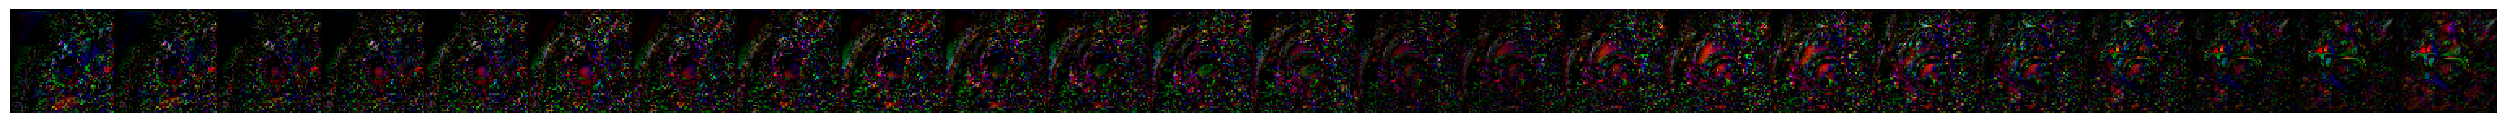

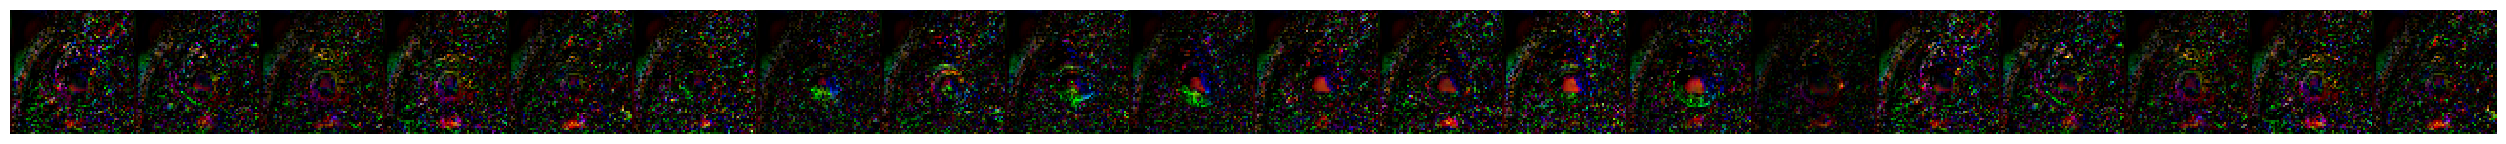

In [5]:
t0_vect = nda_vects[example,0,...]
_ = show_2D_or_3D(t0_vect, interpolation='none')
z8_vect = nda_vects[example,:,8,...]
_ = show_2D_or_3D(z8_vect, interpolation='none')

# 2. Import / define some helper functions

In [6]:
import tensorflow as tf
from src.models.KerasLayers import get_angle_tf,get_angle_np, get_centers_tf,get_idxs_tf
# define two lambdas as wrapper for the angle and min/max normalisation within variable ranges
minmax_lambda = lambda x : x[1] + (((x[0] - np.min(x[0])) * (x[2]-x[1]))/(np.max(x[0]) - np.min(x[0])))
# define some central params
lower, mid, upper = -1,0, 1

In [7]:
# returns a matrix with vectors pointing to the focus point C
def get_focus_tf(p,dim=[12,12,12]):
    return tf.cast(
        tf.tile(tf.convert_to_tensor([*p])[tf.newaxis, tf.newaxis, tf.newaxis, ...],
                (*dim, 1)), tf.float32)

flow2direction_lambda2 = tf.keras.layers.Lambda(
            lambda x: get_angle_tf(x[0], x[1]), name='flow2direction')
print(nda_vects.shape)
dim = np.array(nda_vects.shape[2:-1])

(360, 40, 24, 64, 64, 3)


In [11]:
# define df and helper for pathology extractio
# this should have the same order as our inference data
#df_meta = pd.read_csv(folds_chooser.selected)
df_meta = pd.read_csv('/mnt/sds/sd20i001/sven/data/acdc/02_imported_4D_unfiltered/df_kfold.csv')
df_meta = df_meta.loc[:, ~df_meta.columns.str.contains('^Unnamed')]
df_meta = df_meta[df_meta.patient != 'patient090']  #we excluded this patient
df_meta

,fold,modality,pathology,patient,phase,x_path,y_path
0,3,train,MINF,patient050,ED,data/raw/ACDC/3D/all/patient050/patient050_fra...,data/raw/ACDC/3D/all/patient050/patient050_fra...
1,3,train,MINF,patient050,ES,data/raw/ACDC/3D/all/patient050/patient050_fra...,data/raw/ACDC/3D/all/patient050/patient050_fra...
2,3,train,NOR,patient070,ED,data/raw/ACDC/3D/all/patient070/patient070_fra...,data/raw/ACDC/3D/all/patient070/patient070_fra...
3,3,train,NOR,patient070,ES,data/raw/ACDC/3D/all/patient070/patient070_fra...,data/raw/ACDC/3D/all/patient070/patient070_fra...
4,3,train,RV,patient100,ES,data/raw/ACDC/3D/all/patient100/patient100_fra...,data/raw/ACDC/3D/all/patient100/patient100_fra...
...,...,...,...,...,...,...,...
1595,0,train,NOR,patient072,ED,data/raw/ACDC/3D/train/patient072/patient072_f...,data/raw/ACDC/3D/train/patient072/patient072_f...
1596,0,train,MINF,patient045,ES,data/raw/ACDC/3D/train/patient045/patient045_f...,data/raw/ACDC/3D/train/patient045/patient045_f...
1597,0,train,MINF,patient045,ED,data/raw/ACDC/3D/train/patient045/patient045_f...,data/raw/ACDC/3D/train/patient045/patient045_f...
1598,0,train,HCM,patient032,ES,data/raw/ACDC/3D/train/patient032/patient032_f...,data/raw/ACDC/3D/train/patient032/patient032_f...


In [12]:
patients_df = pd.DataFrame(patients, columns=['pat'])
patients_df['patient'] = patients_df['pat'].map(lambda x : x.split('_')[1])
patients_df['fold'] = patients_df['pat'].map(lambda x : x.split('_')[0])
patients_df

,pat,patient,fold
0,0_patient001_4d.nii.gz\n,patient001,0
1,0_patient002_4d.nii.gz\n,patient002,0
2,0_patient009_4d.nii.gz\n,patient009,0
3,0_patient016_4d.nii.gz\n,patient016,0
4,0_patient018_4d.nii.gz\n,patient018,0
...,...,...,...
94,3_patient087_4d.nii.gz\n,patient087,3
95,3_patient088_4d.nii.gz\n,patient088,3
96,3_patient091_4d.nii.gz\n,patient091,3
97,3_patient093_4d.nii.gz\n,patient093,3


In [13]:
temp = df_meta[df_meta['modality'] == 'test']
temp = temp[temp['phase']=='ED'].drop_duplicates(ignore_index=True, subset='patient')
merged_temp = pd.merge(left=patients_df, right=temp, how='inner', left_on='patient', right_on='patient')
merged_temp

,pat,patient,fold_x,fold_y,modality,pathology,phase,x_path,y_path
0,0_patient001_4d.nii.gz\n,patient001,0,0,test,DCM,ED,data/raw/ACDC/3D/all/patient001/patient001_fra...,data/raw/ACDC/3D/all/patient001/patient001_fra...
1,0_patient002_4d.nii.gz\n,patient002,0,0,test,DCM,ED,data/raw/ACDC/3D/all/patient002/patient002_fra...,data/raw/ACDC/3D/all/patient002/patient002_fra...
2,0_patient009_4d.nii.gz\n,patient009,0,0,test,DCM,ED,data/raw/ACDC/3D/all/patient009/patient009_fra...,data/raw/ACDC/3D/all/patient009/patient009_fra...
3,0_patient016_4d.nii.gz\n,patient016,0,0,test,DCM,ED,data/raw/ACDC/3D/all/patient016/patient016_fra...,data/raw/ACDC/3D/all/patient016/patient016_fra...
4,0_patient018_4d.nii.gz\n,patient018,0,0,test,DCM,ED,data/raw/ACDC/3D/all/patient018/patient018_fra...,data/raw/ACDC/3D/all/patient018/patient018_fra...
...,...,...,...,...,...,...,...,...,...
94,3_patient087_4d.nii.gz\n,patient087,3,3,test,RV,ED,data/raw/ACDC/3D/all/patient087/patient087_fra...,data/raw/ACDC/3D/all/patient087/patient087_fra...
95,3_patient088_4d.nii.gz\n,patient088,3,3,test,RV,ED,data/raw/ACDC/3D/all/patient088/patient088_fra...,data/raw/ACDC/3D/all/patient088/patient088_fra...
96,3_patient091_4d.nii.gz\n,patient091,3,3,test,RV,ED,data/raw/ACDC/3D/all/patient091/patient091_fra...,data/raw/ACDC/3D/all/patient091/patient091_fra...
97,3_patient093_4d.nii.gz\n,patient093,3,3,test,RV,ED,data/raw/ACDC/3D/all/patient093/patient093_fra...,data/raw/ACDC/3D/all/patient093/patient093_fra...


# make sure the general method works

In [14]:
temp = get_focus_tf(dim//2,dim)

In [15]:
temp2 = get_centers_tf(dim)

In [16]:
(temp == temp2).numpy().all()

True

In [8]:
@interact
def show_direction(example=(0,nda_vects.shape[0]-1)):
    print('patient: {}'.format(example))
    print(t0_vect.shape)

    dim = np.array([16,64,64])
    idx = get_idxs_tf(dim)
    c = get_focus_tf(dim//2,dim)
    centers = c - idx
    centers_tensor = centers[tf.newaxis, ...]
    # get the direcrion towards any focus point
    # direction
    directions = get_angle_np(nda_vects[example,...],centers_tensor)[...,0]
    # direction mean
    directions = np.mean(directions,axis=(1,2,3))
    plt.plot(directions); plt.show()
    plt.imshow(gt[example].T);plt.show()

interactive(children=(IntSlider(value=179, description='example', max=359), Output()), _dom_classes=('widget-i…

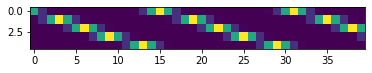

In [18]:
plt.imshow(gt[example].T)

In [9]:
phases = ['ED', 'MS', 'ES', 'PF', 'MD']
if comb_dir is None:
    print('recreate comb dir')
    min_dir = np.zeros((nda_vects.shape[0],16,64,64))
    max_dir = np.zeros((nda_vects.shape[0],16,64,64))
    comb_dir= np.zeros((nda_vects.shape[0],16,64,64))
import scipy
import scipy.misc
@interact
def show(e=(0,nda_vects.shape[0]-1),
         t=(0,nda_vects.shape[1]-1),
        cz=(0,nda_vects.shape[2]-1),
        cx=(0,nda_vects.shape[3]-1),
        cy=(0,nda_vects.shape[4]-1),
         show= ['cmr','norm','mse','dir','heatmap'],
        mask=['none', 'norm','mse'],
        msk_t=(0.0,1.0,0.01),
        c_focus=['coord','norm','mse'],
        reduce=['none','mean', 'median','max']):
    
    ct = np.array([cz,cy,cx])
    patient_id = patients[e].split('_')[1]
    print('patient: {}, pathology: {}'.format(patient_id, merged_temp[merged_temp['patient'] == patient_id]['pathology']))
    fig, (ax1,ax2) = plt.subplots(1,2, figsize=(14,8))
    
    # we have e, t, z --> 2D
    # select two following 2D CMR slices from mov
    # select a 2D vect slice
    
    # calc the norm for this 2D vector slice
    # calc the mse between both following CMR
    # create an empty mask, or based on the norm or the mse
    # if msk_norm or msk_mse, mask the mse, the norm and the 2D vector slice
    
    # calc the com for the norm
    # calc the com for the mse
    
    # define the C_focus matrix based on c_coord, c_norm, c_mse
    # calc the direction based on the masked vect_slice and C_focus as volume with z ==1
    
    
    # get cmr and vect for patient e
    mov_full = minmax_lambda([mov[e,...],0,1])
    mov_full_rolled = np.roll(mov_full, shift=-1,axis=0)
    vect_full = nda_vects[e,...]
    
    # for imshow get the current 2D
    movt_slice = mov_full[t,cz,...,0]
    movtplus_slice = mov_full_rolled[t,cz, ...,0]
    vect_slice = vect_full[t,cz,...]
    
    # calc norm for the 4D volume between t and t+1
    norm_ = np.linalg.norm(vect_full,axis=-1)
    norm_ = clip_quantile(norm_, 0.99)
    norm_ = np.stack([minmax_lambda([elem,0,1]) for elem in norm_], axis=0) # normalise per t, to scope with the cardiac dynamic
    
    # calc mse for the 4D volume between t and t+1
    mse_ = tf.keras.metrics.mean_squared_error(mov_full,mov_full_rolled).numpy()
    mse_ = clip_quantile(mse_, 0.99)
    mse_ = np.stack([minmax_lambda([elem,0,1]) for elem in mse_], axis=0) # normalise per t, to scope with the cardiac dynamic
    
    # reduce the norm along t by one of the following operations, broadcast afterwards
    t_shape = norm_.shape[0]
    if reduce=='mean':
        norm_ = np.mean(norm_, axis=0)
    elif reduce=='median':
        norm_ = np.median(norm_, axis=0)
    elif reduce=='max':
        norm_ = np.max(norm_, axis=0)
    if reduce in ['mean', 'median','max']:
        norm_ = np.broadcast_to(norm_,shape=(t_shape,*norm_.shape))
        
    norm_slice = minmax_lambda([norm_[t,cz],0,1])
    mse_slice = minmax_lambda([mse_[t,cz],0,1])
    
    if mask=='norm':
        msk = (norm_>=msk_t).astype(np.float32)
    elif mask=='mse':
        msk = (mse_>=msk_t).astype(np.float32)
    else:
        msk = np.ones_like(mse_)
    msk_slice = msk[t,cz]
        
    norm_slice = norm_slice * msk_slice
    mse_slice = mse_slice * msk_slice
    
    border = 1
    # alternative calculation, tf ready
    # yf,xf = np.where(mse_slice>dif_t)
    # yf,xf = np.mean(yf),np.mean(xf)
    mse_com = scipy.ndimage.center_of_mass(mse_slice[border:-border,border:-border])
    mse_com = np.array(mse_com) + border
    print('com mse>dif_t: {}'.format(mse_com))
    
    norm_com = scipy.ndimage.center_of_mass(norm_slice[border:-border,border:-border])
    norm_com = np.array(norm_com) + border
    print('com norm>dif_t: {}'.format(norm_com))

    # directions as heatmap for each x,y,z voxel
    heatmap = comb_dir[e,cz]
    ind = np.where(heatmap==np.max(heatmap)) 
    ind_min = np.where(min_dir[e,cz]==np.min(min_dir[e,cz]))
    ind_max = np.where(max_dir[e,cz]==np.max(max_dir[e,cz]))
          
    
    if c_focus == 'mse':
        ct=np.array((cz,mse_com[0],mse_com[1]))
    elif c_focus == 'norm':
        ct=np.array((cz,norm_com[0],norm_com[1]))
    else:
        ct=np.array((cz,cy,cx))
        
          
    dim = np.array([16,64,64])
    idx = get_idxs_tf(dim)
    c = get_focus_tf(ct,dim)
    centers = c - idx
    centers_tensor = centers[tf.newaxis, ...]
    
    # direction 2D
    dir_ = get_angle_np(vect_full,centers_tensor)[...,0]
    #print('dir', dir_.shape)
    dir_slice = dir_[t,cz]*msk_slice
    
    # direction 1D + t
    dir_ = dir_ * msk
    dir_1d = np.mean(dir_, axis=(1,2,3))
    
    norm_ = norm_ * msk
    norm_1d = np.mean(norm_, axis=(1,2,3))
    
    orig= 'upper'
    alpha = 0.4
    print('max diff of {} at y,x: {}'.format(np.max(heatmap), ind))
    #print(ind[1][0],ind[0][0])
    #ax1.scatter(ind_min[1][0],ind_min[0][0], label='min',c='orange', marker='<')
    #ax1.scatter(ind_max[1][0],ind_max[0][0], label='max',c='orange', marker='o')
    ax1.scatter(ind[1][0],ind[0][0], label='com',s=100,c='orange', marker='x')
    ax1.scatter(cx,cy, c='pink', label='select',s=100,marker='o')
    # focus point based on com of sum mse along t
    ax1.scatter(norm_com[1],norm_com[0], c='red',s=100, label='norm_com',marker='<')
    ax1.scatter(mse_com[1],mse_com[0], c='red',s=100, label='mse_com',marker='o')
    ax1.legend(loc='lower right')
    
    im = ax1.imshow(movt_slice, cmap='gray',alpha=1,origin=orig)
    
    if show == 'heatmap': 
        im = ax1.imshow(minmax_lambda([comb_dir[e,cz],0,1]), alpha=alpha,origin=orig)
    elif show == 'norm': 
        im = ax1.imshow(norm_slice, origin=orig, alpha=alpha, cmap='hot')
        
    elif show == 'dir':
        im = ax1.imshow(dir_slice, origin=orig, alpha=alpha, cmap='bwr')
        
    elif show == 'mse':
        im = ax1.imshow(mse_slice, origin=orig, alpha=alpha, cmap='hot')
    
    fig.colorbar(im, orientation='horizontal')
    #_ = ax1.imshow(movt_slice, cmap='gray',alpha=alpha,origin=orig)
    
    
    ax2.imshow(gt[e].T)
    ax2.set_yticks(range(len(phases)), minor=False)
    ax2.set_yticklabels(phases, rotation=0)
    ax3 = ax2.twinx()
    ax3.plot(dir_1d, c = 'red')
    #ax3.plot(norm_1d, c = 'blue')
    if mask:
        ax3.set_ylim([-0.2,0.2])
    else:
        ax3.set_ylim([-0.3,0.3])
    
    ax3.axvline(x=t)
    
    plt.show()

NameError: name 'comb_dir' is not defined

In [10]:
# b,t,z,x,y
import concurrent
from concurrent.futures import as_completed
from time import time
from src.data.Preprocess import clip_quantile

def helper(c_t, e,cz,cy,cx):
    #print(cx,cy)
    # focus point C
    ct = np.array([cz,cy,cx])
    dim = np.array([16,64,64])
    idx = get_idxs_tf(dim)
    c = get_focus_tf(ct,dim)
    centers = c - idx
    centers_tensor = centers[tf.newaxis, ...]

    # direction
    directions = get_angle_np(c_t,centers_tensor)[...,0]
    
    # mask v_t by a threshold norm
    norm_nda = np.linalg.norm(c_t, axis=-1)
    norm_nda = clip_quantile(norm_nda, 0.99)
    norm_nda = minmax_lambda([norm_nda,0,1])
    norm_msk = minmax_lambda([np.max(norm_nda, axis=1),0,1])
    norm_msk = (norm_msk>=0.0).astype(np.float32)[np.newaxis,...] # this could be used to mask v_t by a threshold norm
    directions = directions * norm_msk
    

    # direction mean
    directions = np.mean(directions,axis=(2,3,4))
    min_d = np.min(directions, axis=1)
    max_d = np.max(directions, axis=1)
    comb_d = abs(min_d) + abs(max_d)
    return ct, e, min_d, max_d, comb_d
    

futures = set()
#e = 1
window = 1
cz = 0
t0 = time()
with concurrent.futures.ThreadPoolExecutor(max_workers=12) as executor:
    for e in range(0,nda_vects.shape[0]-1,window):
        for cz in range(0,nda_vects.shape[2],4):
            for cx in range(0,nda_vects.shape[3],8):
                for cy in range(0,nda_vects.shape[4],8):
                    futures.add(executor.submit(helper, nda_vects[e:e+window], e,cz,cy,cx))
                    #print(cx,cy)
        #print('patient: {}'.format(e))
print('all threads started : {}'.format(time()- t0))                            

KeyboardInterrupt: 

In [26]:
for i, future in enumerate(as_completed(futures)):
    ct,e, min_d,max_d,comb_d = future.result()
    cz,cy,cx = ct
    min_dir[e:e+window,cz,cy,cx] = min_d
    max_dir[e:e+window,cz,cy,cx] = max_d
    comb_dir[e:e+window,cz,cy,cx] = comb_d

In [123]:
len(futures)

50176

In [22]:
mov[0].shape

(40, 16, 64, 64, 1)

# Find focus point unsupervised via mean squared error over time

In [64]:
import tensorflow as tf
@interact
def show_mse_center(e=(0,mov.shape[0]-1)):
    threshold = 0.01
    temp = mov[e]
    temp_roll = np.roll(temp, shift=-1,axis=0)
    mse_ = tf.keras.metrics.mean_squared_error(temp,temp_roll).numpy()
    mse_mean = np.mean(mse_,axis=0)
    zf,yf,xf = np.where(mse_mean>threshold)
    print(zf.mean(),xf.mean(), yf.mean())
    comz, comy, comx = scipy.ndimage.center_of_mass(mse_mean)
    print(comz, comy, comx)
    plt.hist(mse_.flatten())
    _= show_2D_or_3D(temp[0], mse_mean>threshold)
    plt.show()

interactive(children=(IntSlider(value=49, description='e', max=98), Output()), _dom_classes=('widget-interact'…

In [125]:
np.save('data/predicted/min_max_comb_direction_per_voxel_acdc_center.npz',np.stack([min_dir,max_dir, comb_dir]))